In [28]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
pip install stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Required Libraries.**

In [31]:
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from torch.utils.data import DataLoader,Dataset
from torch.optim import AdamW
from transformers import get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import time
from transformers import DistilBertTokenizerFast
from transformers.optimization import get_linear_schedule_with_warmup

**General Setting.**

In [67]:
torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_EPOCHS = 5

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Read Dataset.**

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
data = pd.read_csv('/content/drive/MyDrive/DL dataset/CoronaTweetsSentimentAnalysis.csv')
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low price...,Positive
4,5,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive
...,...,...,...,...,...,...
1983,1984,48737,Paraparaumu Beach,16-03-2020,Just been through K?piti New World which is bu...,Positive
1984,1985,48743,"Cincinnati, Ohio",16-03-2020,"Even though the Law Library is closed, ALL sub...",Positive
1985,1986,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call...",Negative
1986,1987,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive


In [36]:
data['Sentiment'].value_counts()

Negative    1041
Positive     947
Name: Sentiment, dtype: int64

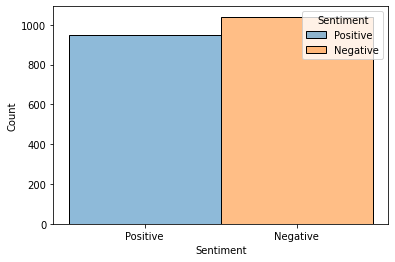

In [37]:
sns.histplot(data = data, x="Sentiment", hue = "Sentiment")
plt.show()

**Data Cleaning.**

In [38]:
data = data.drop(['UserName','ScreenName','Location','TweetAt'], axis = 1)

In [39]:
data

,OriginalTweet,Sentiment
0,When I couldn't find hand sanitizer at Fred Me...,Positive
1,#Panic buying hits #NewYork City as anxious sh...,Negative
2,Voting in the age of #coronavirus = hand sanit...,Positive
3,Best quality couches at unbelievably low price...,Positive
4,While we were busy watching election returns a...,Positive
...,...,...
1983,Just been through K?piti New World which is bu...,Positive
1984,"Even though the Law Library is closed, ALL sub...",Positive
1985,"@RicePolitics @MDCounties Craig, will you call...",Negative
1986,Meanwhile In A Supermarket in Israel -- People...,Positive


In [40]:
X = data['OriginalTweet']
Y = data['Sentiment']
tweets = list(X)

Tweet before cleaning.

In [41]:
data['OriginalTweet'][1]

'#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?\r\r\n\r\r\nhttps://t.co/IASiReGPC4\r\r\n\r\r\n#QAnon #QAnon2018 #QAnon2020 \r\r\n#Election2020 #CDC https://t.co/29isZOewxu'

In [42]:
def preprocessing_text(text):
    text = text.lower()                     # converting upper case to lower case
    text = re.sub(r'\d+', '', text)         # removing numbers
    text = re.sub('[^a-zA-Z]', ' ', text)   # removing punctuations
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r"http\S+", "", text)
    return text

In [43]:
x = []
for review in tweets:
    x.append(preprocessing_text(review))
x[1]

' panic buying hits newyork city as anxious shoppers stock up on food amp medical supplies after healthcare worker in her s becomes bigapple st confirmed coronavirus patient or a bloomberg staged event  t co iasiregpc qanon qanon qanon election cdc  t co iszoewxu'

In [44]:
sw_nltk = stopwords.words('english')
print(sw_nltk)
for i in range(len(x)):
  words = [word for word in x[i].split() if word.lower() not in sw_nltk]
  x[i] = " ".join(words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Tweet after cleaning.

In [45]:
x[1]

'panic buying hits newyork city anxious shoppers stock food amp medical supplies healthcare worker becomes bigapple st confirmed coronavirus patient bloomberg staged event co iasiregpc qanon qanon qanon election cdc co iszoewxu'

**Label Encoding.**

In [46]:
y = list(Y)
le = LabelEncoder()
y= le.fit_transform(y)
y=list(y)

In [47]:
df = pd.DataFrame(list(zip(x, y)),columns =['Tweet', 'Sentiment'])
df

,Tweet,Sentiment
0,find hand sanitizer fred meyer turned amazon p...,1
1,panic buying hits newyork city anxious shopper...,0
2,voting age coronavirus hand sanitizer supertue...,1
3,best quality couches unbelievably low prices a...,1
4,busy watching election returns bracing covid o...,1
...,...,...
1983,k piti new world busy staff say way since covi...,1
1984,even though law library closed subscribers acc...,1
1985,ricepolitics mdcounties craig call general ass...,0
1986,meanwhile supermarket israel people dance sing...,1


**Train, Test and Validation split.**

In [48]:
train_texts = df.iloc[:1491]['Tweet'].values
train_labels = df.iloc[:1491]['Sentiment'].values

valid_texts = df.iloc[1491:1590]['Tweet'].values
valid_labels = df.iloc[1491:1590]['Sentiment'].values

test_texts = df.iloc[1590:]['Tweet'].values
test_labels = df.iloc[1590:]['Sentiment'].values

**Tokenization.**

In [49]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [50]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [51]:
train_encodings[0]

Encoding(num_tokens=95, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

**Dataset Class and Loaders.**

In [52]:
class CoronaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CoronaDataset(train_encodings, train_labels)
valid_dataset = CoronaDataset(valid_encodings, valid_labels)
test_dataset = CoronaDataset(test_encodings, test_labels)

In [68]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

**Load Model.**

In [69]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train()

# Adam with weight decay, https://arxiv.org/abs/1711.05101
optim = torch.optim.AdamW(model.parameters(),
                          lr=5e-5,
                          weight_decay=0.01)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [70]:
scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=50,
    num_training_steps=len(train_loader) * NUM_EPOCHS)

**Model Train.**

In [71]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [72]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, batch in enumerate(train_loader):
        
        
        
        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        ### Forward
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        
        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step()
        
        ### Logging
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')
            
    model.eval()

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 0001/0005 | Batch 0000/0373 | Loss: 0.6461
Epoch: 0001/0005 | Batch 0250/0373 | Loss: 0.5803
training accuracy: 75.12%
valid accuracy: 66.67%
Time elapsed: 0.45 min
Epoch: 0002/0005 | Batch 0000/0373 | Loss: 0.3937
Epoch: 0002/0005 | Batch 0250/0373 | Loss: 0.6367
training accuracy: 84.24%
valid accuracy: 64.65%
Time elapsed: 0.89 min
Epoch: 0003/0005 | Batch 0000/0373 | Loss: 0.3643
Epoch: 0003/0005 | Batch 0250/0373 | Loss: 0.0310
training accuracy: 96.78%
valid accuracy: 71.72%
Time elapsed: 1.32 min
Epoch: 0004/0005 | Batch 0000/0373 | Loss: 0.0382
Epoch: 0004/0005 | Batch 0250/0373 | Loss: 0.0203
training accuracy: 99.20%
valid accuracy: 71.72%
Time elapsed: 1.77 min
Epoch: 0005/0005 | Batch 0000/0373 | Loss: 0.1694
Epoch: 0005/0005 | Batch 0250/0373 | Loss: 0.0059
training accuracy: 99.60%
valid accuracy: 70.71%
Time elapsed: 2.21 min
Total Training Time: 2.21 min
Test accuracy: 75.13%
